In [14]:
!git clone https://github.com/facebookresearch/perception_models.git

Cloning into 'perception_models'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 747 (delta 191), reused 123 (delta 123), pack-reused 508 (from 2)
Receiving objects: 100% (747/747), 13.29 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (355/355), done.


In [17]:
import os
import sys
import torch
from tqdm import tqdm
from PIL import Image
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Add model paths
sys.path.append('/kaggle/working/perception_models')
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms_pe

# -----------------------------
# CONFIG
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "PE-Core-S16-384"  # Must match search.py
DB_ROOT = "/workspace/rahul/final/milvusdb"
IMAGE_FOLDER = "/kaggle/input/coco-2017-dataset/coco2017/val2017"  # source of frames
COLLECTION_NAME = "frame_embeddings_db"

# Path where Milvus Lite DB will be saved
DB_PATH = os.path.join('/kaggle/working/', model_name, "frame_source_db", "milvus.db")
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# -----------------------------
# 1. Load CLIP Model
# -----------------------------
print("[+] Loading CLIP model:", model_name)
model = pe.CLIP.from_config(model_name, pretrained=True)
model = model.eval().to(device)

preprocess = transforms_pe.get_image_transform(model.image_size)

# -----------------------------
# 2. Connect to Milvus Lite
# -----------------------------
print(f"[+] Connecting to Milvus Lite DB: {DB_PATH}")
# Disconnect if same alias is already active
if connections.has_connection("default"):
    connections.disconnect("default")

connections.connect(alias="default", uri=DB_PATH)


# -----------------------------
# 3. Define Collection Schema
# -----------------------------
if utility.has_collection(COLLECTION_NAME):
    print("[✓] Existing collection found. Loading...")
    collection = Collection(COLLECTION_NAME)
else:
    print("[+] Creating new collection schema...")

    # Get embedding dimension dynamically
    dummy_img = next(f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
    dummy_path = os.path.join(IMAGE_FOLDER, dummy_img)
    dummy_tensor = preprocess(Image.open(dummy_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        dummy_emb = model.encode_image(dummy_tensor)
        emb_dim = dummy_emb.shape[-1]

    fields = [
        FieldSchema(name="id", dtype=DataType.VARCHAR, is_primary=True, max_length=256),
        FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=emb_dim),
    ]
    schema = CollectionSchema(fields, description="Frame-level CLIP embeddings")
    collection = Collection(name=COLLECTION_NAME, schema=schema)
    print("[✓] New collection created:", COLLECTION_NAME)

# -----------------------------
# 4. Index Images
# -----------------------------
def encode_image(image_path):
    image = preprocess(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(image)
        features /= features.norm(dim=-1, keepdim=True)
    return features.squeeze().cpu().tolist()

def index_images(image_dir, collection):
    image_files = [
        f for f in os.listdir(image_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    print(f"[+] Found {len(image_files)} images to index.")

    ids, vectors = [], []
    for img_file in tqdm(image_files, desc="Embedding images"):
        img_path = os.path.join(image_dir, img_file)
        try:
            emb = encode_image(img_path)
            img_id = os.path.splitext(img_file)[0]  # filename without extension
            ids.append(img_id)
            vectors.append(emb)
        except Exception as e:
            print(f"[!] Skipping {img_file}: {e}")

    if len(ids) > 0:
        collection.insert([ids, vectors])
        print(f"[✓] Inserted {len(ids)} image embeddings into Milvus collection.")
    else:
        print("[!] No valid images were indexed.")

# -----------------------------
# 5. Build Index
# -----------------------------
def create_index(collection):
    print("[+] Creating index...")
    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "COSINE",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="vector", index_params=index_params)
    print("[✓] Index created successfully.")

# -----------------------------
# 6. Main Logic
# -----------------------------
if __name__ == "__main__":
    try:
        # Only index if empty
        if collection.num_entities == 0:
            index_images(IMAGE_FOLDER, collection)
            create_index(collection)
        else:
            print(f"[✓] Collection already has {collection.num_entities} entries. Skipping indexing.")

        collection.flush()
        print("[✓] All embeddings flushed and ready for search.")

    except Exception as e:
        print(f"[✗] Error during indexing: {e}")

    finally:
        if connections.has_connection("default"):
            connections.disconnect("default")
            print("[✓] Disconnected from Milvus.")


[+] Loading CLIP model: PE-Core-S16-384


PE-Core-S16-384.pt:   0%|          | 0.00/349M [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []
[+] Connecting to Milvus Lite DB: /kaggle/working/PE-Core-S16-384/frame_source_db/milvus.db
[+] Creating new collection schema...
[✓] New collection created: frame_embeddings_db
[+] Found 5000 images to index.


Embedding images: 100%|██████████| 5000/5000 [02:55<00:00, 28.51it/s]


[✓] Inserted 5000 image embeddings into Milvus collection.
[+] Creating index...
[✓] Index created successfully.
[✓] All embeddings flushed and ready for search.
[✓] Disconnected from Milvus.


[+] Loading CLIP model: PE-Core-S16-384
Missing keys for loading model: []
Unexpected keys for loading model: []
[+] Connecting to Milvus Lite DB: /kaggle/working/PE-Core-S16-384/frame_source_db/milvus.db
[✓] Connected to Milvus Lite DB: /kaggle/working/PE-Core-S16-384/frame_source_db/milvus.db
[✓] Collection loaded: frame_embeddings_db



Enter your search query (or 'exit' to quit):  Red car



[INFO] Searching for: 'Red car' ...


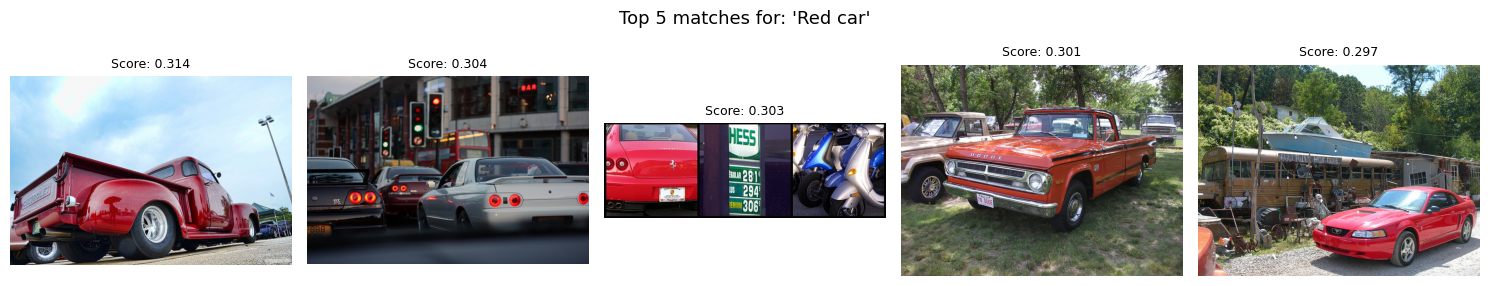


[✓] Top Retrieved Image Paths:
   /kaggle/input/coco-2017-dataset/coco2017/val2017/000000041633.jpg
   /kaggle/input/coco-2017-dataset/coco2017/val2017/000000454661.jpg
   /kaggle/input/coco-2017-dataset/coco2017/val2017/000000527220.jpg
   /kaggle/input/coco-2017-dataset/coco2017/val2017/000000148719.jpg
   /kaggle/input/coco-2017-dataset/coco2017/val2017/000000543043.jpg



Enter your search query (or 'exit' to quit):  exit


[✓] Disconnected from Milvus.


In [19]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pymilvus import connections, Collection

# -------------------------------------------------
# 1. Import perception model modules
# -------------------------------------------------
sys.path.append('/kaggle/working/perception_models')
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms_pe

# -------------------------------------------------
# 2. CONFIG — must match create.py
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "PE-Core-S16-384"  # must match create.py
DB_PATH = os.path.join('/kaggle/working/', model_name, "frame_source_db", "milvus.db")
COLLECTION_NAME = "frame_embeddings_db"

IMAGE_FOLDER = "/kaggle/input/coco-2017-dataset/coco2017/val2017"  # image source folder
TOP_K = 5  # Number of results to show

# -------------------------------------------------
# 3. Load CLIP Model
# -------------------------------------------------
print(f"[+] Loading CLIP model: {model_name}")
model = pe.CLIP.from_config(model_name, pretrained=True)
model = model.eval().to(device)
tokenizer = transforms_pe.get_text_tokenizer(model.context_length)

# -------------------------------------------------
# 4. Connect to Milvus Lite
# -------------------------------------------------
if connections.has_connection("default"):
    connections.disconnect("default")

print(f"[+] Connecting to Milvus Lite DB: {DB_PATH}")
connections.connect(alias="default", uri=DB_PATH)
collection = Collection(name=COLLECTION_NAME, using="default")
collection.load()

print(f"[✓] Connected to Milvus Lite DB: {DB_PATH}")
print(f"[✓] Collection loaded: {COLLECTION_NAME}")

# -------------------------------------------------
# 5. Encode Text Query
# -------------------------------------------------
def encode_text(query: str):
    text_tokens = tokenizer([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.squeeze().cpu().tolist()

# -------------------------------------------------
# 6. Search & Plot Results
# -------------------------------------------------
def search_and_show(query, top_k=TOP_K):
    query_vector = encode_text(query)
    search_params = {"metric_type": "COSINE", "params": {}}

    results = collection.search(
        data=[query_vector],
        anns_field="vector",
        param=search_params,
        limit=top_k,
        output_fields=["id"],
    )

    if not results or not results[0]:
        print("[!] No matches found.")
        return []

    hits = results[0]
    filepaths, scores = [], []

    for hit in hits:
        img_id = hit.id
        possible_paths = [
            os.path.join(IMAGE_FOLDER, f"{img_id}.jpg"),
            os.path.join(IMAGE_FOLDER, f"{img_id}.jpeg"),
            os.path.join(IMAGE_FOLDER, f"{img_id}.png"),
        ]
        found_path = next((p for p in possible_paths if os.path.exists(p)), None)

        if found_path:
            filepaths.append(found_path)
            scores.append(hit.score)
        else:
            print(f"[!] Missing file for ID: {img_id}")

    # --- Plot results ---
    if not filepaths:
        print("[!] No valid image files to display.")
        return []

    plt.figure(figsize=(15, 3))
    for i, (fp, sc) in enumerate(zip(filepaths, scores)):
        try:
            img = Image.open(fp).convert("RGB")
            plt.subplot(1, len(filepaths), i + 1)
            plt.imshow(img)
            plt.title(f"Score: {sc:.3f}", fontsize=9)
            plt.axis("off")
        except Exception as e:
            print(f"[!] Error displaying {fp}: {e}")

    plt.suptitle(f"Top {len(filepaths)} matches for: '{query}'", fontsize=13)
    plt.tight_layout()
    plt.show()

    return filepaths

# -------------------------------------------------
# 7. Main Loop
# -------------------------------------------------
if __name__ == "__main__":
    try:
        while True:
            query = input("\nEnter your search query (or 'exit' to quit): ").strip()
            if query.lower() == "exit":
                break

            print(f"\n[INFO] Searching for: '{query}' ...")
            top_images = search_and_show(query, TOP_K)

            if top_images:
                print("\n[✓] Top Retrieved Image Paths:")
                for path in top_images:
                    print("  ", path)

    except Exception as e:
        print(f"[✗] Error: {e}")
    finally:
        if connections.has_connection("default"):
            connections.disconnect("default")
        print("[✓] Disconnected from Milvus.")
